In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('TIH Expenditure Data_cleaned_copy1.csv')

In [3]:
df.dtypes

INVOICE_NO                           object
INVOICE_DT                           object
Payment_Date                         object
PAYMENT_PARTY                        object
NARRATION                            object
INVOICE_VALUE_WITHOUT_GST_OR_TDS    float64
CGST                                float64
SGST                                float64
IGST                                float64
GROSS AMOUNT                        float64
P TAX (-)                           float64
TDS AMOUT (-)                       float64
ROUND UP (+)                        float64
ROUND OFF (-)                       float64
NET AMOUNT PAID                     float64
TDS PERCENTAGE                      float64
PAN NO                               object
PV DATE                              object
PV NO                                object
EXP TYPE                             object
EXPENSE HEAD                         object
PROJECT CODE                         object
GST_Rate                        

In [4]:
df['Payment_Date'] = pd.to_datetime(df['Payment_Date'], errors='coerce', format='mixed')

In [5]:
df_agg_weekly = df.groupby(pd.Grouper(key='Payment_Date', freq='W'))['GROSS AMOUNT'].sum().reset_index() # summing up over each week
df_agg_weekly = df_agg_weekly.set_index('Payment_Date')
df_agg_weekly

,GROSS AMOUNT
Payment_Date,
2024-06-30,2197796.71
2024-07-07,1824504.86
2024-07-14,777945.50
2024-07-21,31672.99
2024-07-28,9350.00
2024-08-04,825874.00
2024-08-11,248876.03
2024-08-18,92029.90
2024-08-25,50401.30


In [6]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_agg_weekly.dropna())
# Extract and print the results
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Number of lags used: {}".format(result[2]))
print("Number of observations used: {}".format(result[3]))

# Critical values
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

# Interpretation
if result[1] <= 0.05:
    print("=> Reject the null hypothesis (H0): The series is stationary.")
else:
    print("=> Fail to reject the null hypothesis (H0): The series is non-stationary.")


ADF Statistic: -1.1654
p-value: 0.6883
Number of lags used: 8
Number of observations used: 29
Critical Value (1%): -3.6791
Critical Value (5%): -2.9679
Critical Value (10%): -2.6232
=> Fail to reject the null hypothesis (H0): The series is non-stationary.


In [7]:
ts = df_agg_weekly.diff().dropna()
result = adfuller(ts.dropna())
# Extract and print the results
print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
print("Number of lags used: {}".format(result[2]))
print("Number of observations used: {}".format(result[3]))
# Interpretation
if result[1] <= 0.05:
    print("=> Reject the null hypothesis (H0): The series is stationary.")
else:
    print("=> Fail to reject the null hypothesis (H0): The series is non-stationary.")

# Series becomes stationary after differencing it once. so, d=1.

ADF Statistic: -3.3786
p-value: 0.0117
Number of lags used: 7
Number of observations used: 29
=> Reject the null hypothesis (H0): The series is stationary.


In [8]:
train_data, test_data = df_agg_weekly['GROSS AMOUNT'][:-6], df_agg_weekly['GROSS AMOUNT'][-6:]
train_data.info()
print(len(train_data))
print(len(test_data))

<class 'pandas.core.series.Series'>
DatetimeIndex: 32 entries, 2024-06-30 to 2025-02-02
Series name: GROSS AMOUNT
Non-Null Count  Dtype  
--------------  -----  
32 non-null     float64
dtypes: float64(1)
memory usage: 512.0 bytes
32
6


In [9]:
#ARMA : d=0
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_arma = ARIMA(train_data, order = (1,1,1), enforce_stationarity=False) #orders obtained from acf, pacf plots
model_arma_fit = model_arma.fit()

predictions_arma = model_arma_fit.predict(
    start = len(train_data),
    end = len(train_data) + len(test_data) - 1, dynamic=False)

mse = mean_squared_error(predictions_arma, test_data)
mae = mean_absolute_error(predictions_arma, test_data)
#r2 = r2_score(predictions_arma, test_data)
print(f"MAE: {mae}, MSE: {mse}")


def smape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    denominator = (np.abs(actual) + np.abs(forecast)) / 2.0
    diff = np.abs(actual - forecast) / denominator
    diff[denominator == 0] = 0.0  # avoid division by zero
    return 100 * np.mean(diff)
smape = smape(test_data, predictions_arma)
print(f"SMAPE: {smape}")

MAE: 1681765.8953817056, MSE: 3047953458011.4126
SMAPE: 133.19206813373066


C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\Srija Upadhyay\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


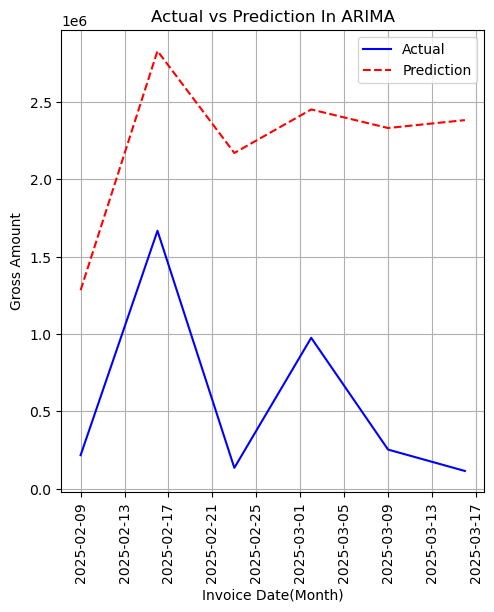

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(test_data.index, test_data.values, label='Actual', color = 'blue')
plt.plot(test_data.index, predictions_arma.values, label='Prediction', color = 'red', linestyle = "--")
plt.title('Actual vs Prediction In ARIMA')
plt.xlabel('Invoice Date(Month)')
plt.xticks(rotation=90)
plt.ylabel('Gross Amount')
plt.legend()
plt.grid()
plt.show()

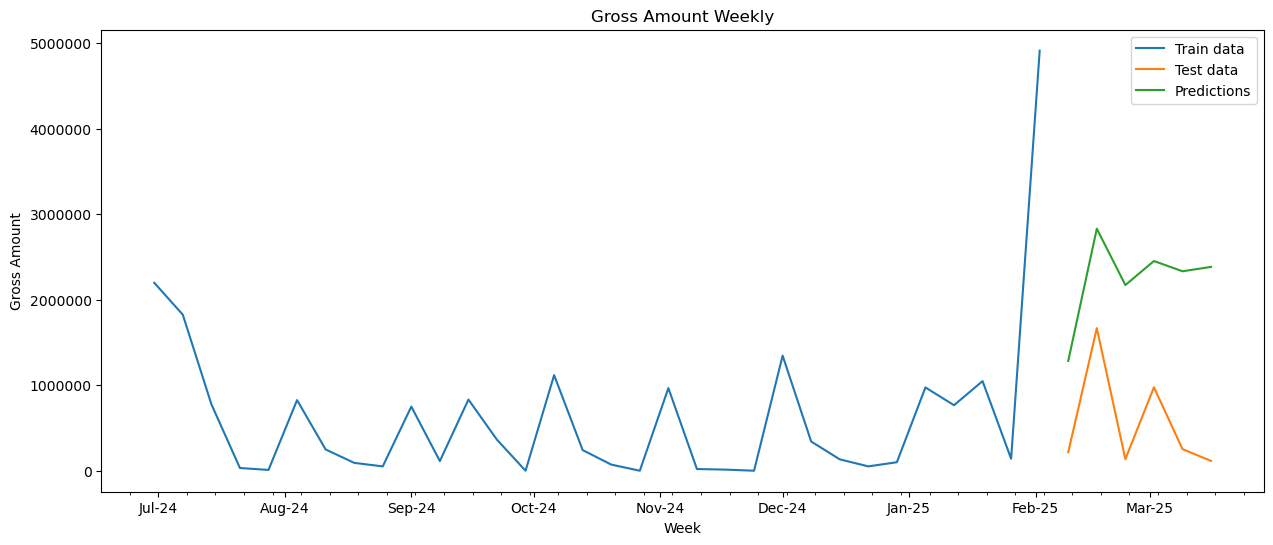

In [11]:
from matplotlib.dates import WeekdayLocator, DateFormatter
plt.figure(figsize=(15,6))
# Data for the first plot
x1 = test_data.index
y1 = test_data

# Data for the second plot
x2 = train_data.index
y2 = train_data
# Data for the second plot
x3 = predictions_arma.index
y3 = predictions_arma

# Plot both lines on the same axes
plt.plot(x2, y2, label='Train data')
plt.plot(x1, y1, label='Test data')
plt.plot(x3, y3, label='Predictions')


# Add labels and a legend for clarity
ax=plt.gca()
plt.xlabel("Week")
plt.ylabel("Gross Amount")
plt.title("Gross Amount Weekly")
ax.xaxis.set_minor_locator(WeekdayLocator(byweekday=0))  # Mondays
ax.xaxis.set_major_formatter(DateFormatter('%b-%y'))
ax.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.savefig('ARIMA_predictions.png')
plt.show()

In [3]:
# mae difference from monthly model
# weekly - monthly
1681765.8953817056 - 3705594.7471623425

-2023828.851780637

In [4]:
# mse difference from monthly model
# weekly - monthly
3047953458011.4126 - 16021490461165.494

-12973537003154.082